# SC Model#
$$V_i(t) =\eta(t)\left(\frac{1}{2}\tanh\left(\frac{U_i(t) - \theta}{\beta}\right)+ \frac{1}{2} \right)$$
$$\theta = 0.05, \beta = 0.5$$
$$v = \begin{bmatrix} V_{LP} \\ V_{LA} \\ V_{RA} \\ V_{RP} \end{bmatrix} \hspace{1cm} u = \begin{bmatrix} U_{LP} \\ U_{LA} \\ U_{RA} \\ U_{RP} \end{bmatrix}$$
$$\tau \frac{\partial u}{\partial t} = -u + Wv + I + \sigma \partial W$$
$$\tau = 0.09, \partial t = 0.024$$
$$W = \begin{bmatrix} sW_P & vW_{PA} &  dW_{PA} & hW_P \\ vW_{AP}  & sW_A & hW_A  & dW_{AP} \\ dW_{AP} & hW_P & sW_A & vW_{AP}  \\  hW_A & dW_{PA} & vW_{PA}  & sW_P \end{bmatrix}$$

## Reduced parameterization ##
We will simplify our parameterization of the weight matrix for now to the following:
$$W = \begin{bmatrix} sW & vW &  dW & hW \\ vW  & sW & hW  & dW \\ dW & hW & sW & vW  \\  hW & dW & vW & sW \end{bmatrix}$$

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

theta = 0.05
beta = 0.5
dt = 0.024
tau = 0.09

/Users/sbittner/anaconda/envs/dsn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


### Initialize parameters to means from Fig. S6 ###

In [2]:
# weight matrix
sW = 1.0
hW = 0.1
vW = -1.0
dW = 0.5
W = np.array([[sW, vW, dW, hW], [vW, sW, hW, dW], [dW, hW, sW, vW], [hW, dW, vW, sW]])

# dynamics parameters
sigma = 0.3

# input coefficients
E_constant = 0.0
E_Pbias = 0.1
E_Prule = 0.5
E_Arule = 0.5
E_choice = -0.2
E_light = 0.1

### Construct the inputs ###

$$I_{\text{constant}}(t) = E_{\text{constant}} \begin{bmatrix} 1 & 1 & 1 & 1 \end{bmatrix}^\top $$
$$I_{\text{P,bias}}(t) = E_{\text{P,bias}} \begin{bmatrix} 1 & 0 & 0 & 1 \end{bmatrix}^\top$$
$$I_{\text{P,rule}}(t) = \begin{cases}
                           E_{\text{P,rule}} \begin{bmatrix} 1 & 0 & 0 & 1 \end{bmatrix}^\top,& \text{if } t\leq 1.2s \\
                            0,              & \text{otherwise}
                         \end{cases}$$
$$I_{\text{A,rule}}(t) = \begin{cases}
                           E_{\text{A,rule}} \begin{bmatrix} 0 & 1 & 1 & 0 \end{bmatrix}^\top,& \text{if } t\leq 1.2s \\
                            0,              & \text{otherwise}
                         \end{cases}$$
$$I_{\text{choice}}(t) = \begin{cases}
                           E_{\text{choice}} \begin{bmatrix} 1 & 1 & 1 & 1 \end{bmatrix}^\top,& \text{if } t > 1.2s \\
                            0,              & \text{otherwise}
                         \end{cases}$$
$$I_{\text{light}}(t) = \begin{cases}
                           E_{\text{light}} \begin{bmatrix} 1 & 1 & 0 & 0 \end{bmatrix}^\top,& \text{if } t > 1.2s \text{and Left} \\
                           E_{\text{light}} \begin{bmatrix} 0 & 0 & 1 & 1 \end{bmatrix}^\top,& \text{if } t > 1.2s \text{and Right} \\
                            0,              & t \leq 1.2s
                         \end{cases}$$

In [3]:
t_cue_delay = 1.2
t_choice = 0.6
t_total = t_cue_delay + t_choice
t = np.arange(0, t_total, dt)
T = t.shape[0]

I_constant = np.tile(E_constant*np.array([[1, 1, 1, 1]]), (T, 1))

I_Pbias = np.zeros((T,4))
I_Pbias[t < 1.2] = E_Pbias*np.array([1, 0, 0, 1])

I_Prule = np.zeros((T,4))
I_Prule[t < 1.2] = E_Prule*np.array([1, 0, 0, 1])

I_Arule = np.zeros((T,4))
I_Arule[t < 1.2] = E_Arule*np.array([0, 1, 1, 0])

I_choice = np.zeros((T,4))
I_choice[t > 1.2] = E_choice*np.array([1, 1, 1, 1])

I_lightL = np.zeros((T,4))
I_lightL[t > 1.2] = E_light*np.array([1, 1, 0, 0])

I_lightR = np.zeros((T,4))
I_lightR[t > 1.2] = E_light*np.array([0, 0, 1, 1])

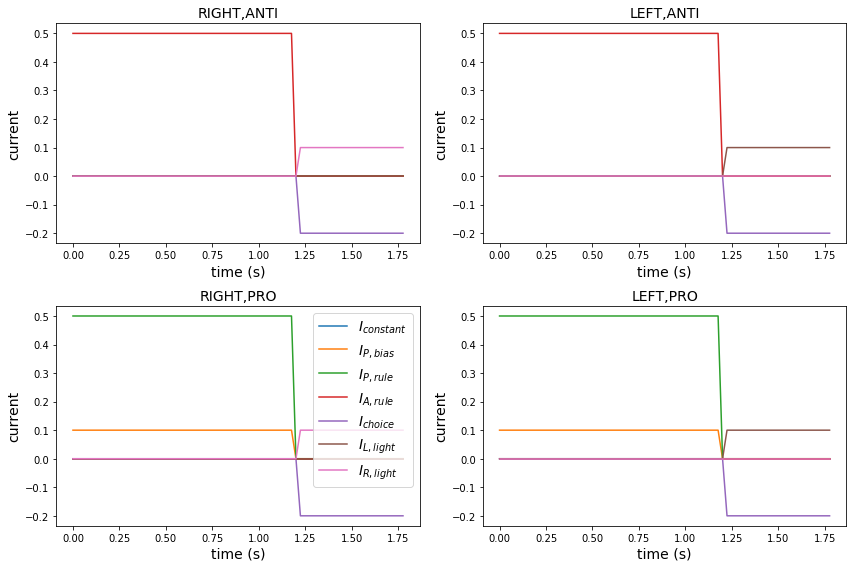

In [18]:
fontsize = 14
titles = ['LEFT,PRO', 'LEFT,ANTI', 'RIGHT,ANTI', 'RIGHT,PRO']
row_inds = [1, 0, 0, 1]
col_inds = [1, 1, 0, 0]
fig, axs = plt.subplots(2,2,figsize=(12,8))
ind = 0
for ind in range(4):
    ax = axs[row_inds[ind]][col_inds[ind]]
    ax.plot(t, I_constant[:,ind], label=r'$I_{constant}$')
    ax.plot(t, I_Pbias[:,ind], label=r'$I_{P,bias}$')
    ax.plot(t, I_Prule[:,ind], label=r'$I_{P,rule}$')
    ax.plot(t, I_Arule[:,ind], label=r'$I_{A,rule}$')
    ax.plot(t, I_choice[:,ind], label=r'$I_{choice}$')
    ax.plot(t, I_lightL[:,ind], label=r'$I_{L,light}$')
    ax.plot(t, I_lightR[:,ind], label=r'$I_{R,light}$')
    ax.set_xlabel('time (s)', fontsize=fontsize)
    ax.set_ylabel('current', fontsize=fontsize)
    ax.set_title(titles[ind], fontsize=fontsize)
    if (ind==3):
        ax.legend(fontsize=fontsize)
plt.tight_layout()
plt.show()

In [5]:
# add broadcasting dimension to input
I_constant = np.expand_dims(I_constant, 2)
I_Pbias = np.expand_dims(I_Pbias, 2)
I_Prule = np.expand_dims(I_Prule, 2)
I_Arule = np.expand_dims(I_Arule, 2)
I_choice = np.expand_dims(I_choice, 2)
I_lightL = np.expand_dims(I_lightL, 2)
I_lightR = np.expand_dims(I_lightR, 2)

I_LP = I_constant + I_Pbias + I_Prule + I_choice + I_lightL
I_LA = I_constant + I_Pbias + I_Arule + I_choice + I_lightL
I_RA = I_constant + I_Pbias + I_Arule + I_choice + I_lightR
I_RP = I_constant + I_Pbias + I_Prule + I_choice + I_lightR

In [7]:
ntrials = 100

u = np.zeros((T, 4, ntrials))
v = np.zeros((T, 4, ntrials))
w = np.random.normal(0.0, 1.0, (T-1, 4, ntrials))

# initialization
v0 = np.array([0.1, 0.08, 0.09, 0.11])
u0 = beta*np.arctanh(2*v0 - 1) - theta

for i in range(ntrials):
    v[0,:,i] = v0
    u[0,:,i] = u0

for i in range(1,T):
    du = (dt/tau) * (-u[i-1] + np.dot(W, v[i-1]) + I_LP[i] + sigma*w[i-1])
    u[i] = u[i-1]+du
    v[i] = 0.5*np.tanh((u[i] - theta)/beta) + 0.5
    


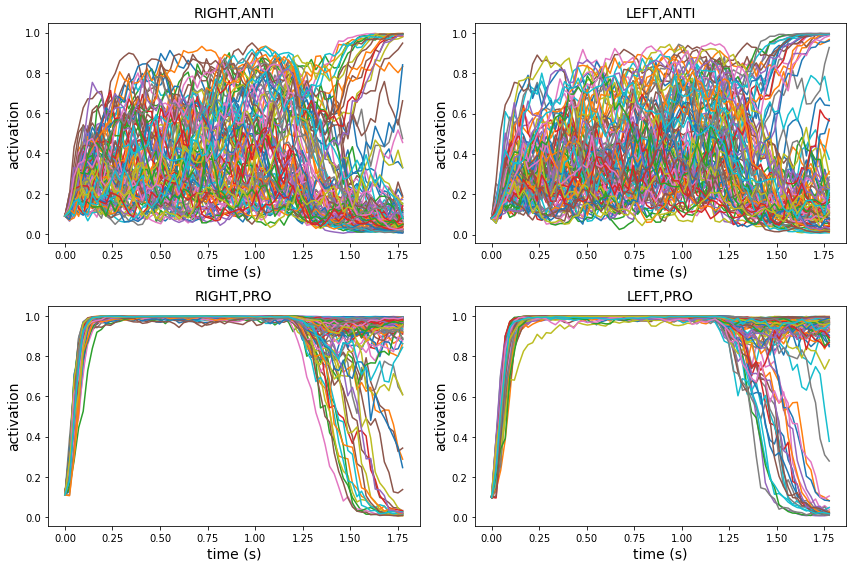

In [21]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
for ind in range(4):
    ax = axs[row_inds[ind]][col_inds[ind]]
    ax.plot(t, v[:,ind,:])
    ax.set_xlabel('time (s)', fontsize=fontsize)
    ax.set_ylabel('activation', fontsize=fontsize)
    ax.set_title(titles[ind], fontsize=fontsize)
plt.tight_layout()
plt.show()

(75, 4, 100)
